# Need GPU!!!

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
# Change Directory
import os

os.chdir('/gdrive/My Drive/Recommender/Movie Lense/')
print(os.getcwd())

/gdrive/My Drive/Recommender/Movie Lense


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install surprise
from surprise import Dataset

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.python.keras.models import Model, model_from_json

from keras.utils import plot_model

     |████████████████████████████████| 11.8MB 11.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670922 sha256=70988ca3808fc497d0a7a1ac88f681494390e3696a97914c7f8b5a66caffa1eb
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# Data Preprocessing

In [4]:
data = Dataset.load_builtin('ml-1m')
df = pd.DataFrame(data.raw_ratings)
df.columns = ['user_emb_id', 'movie_emb_id', 'rating', 'timestampe']
df['user_emb_id'] = df['user_emb_id'].astype(int)
df['movie_emb_id'] = df['movie_emb_id'].astype(int)
df

Dataset ml-1m could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /root/.surprise_data/ml-1m


,user_emb_id,movie_emb_id,rating,timestampe
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
...,...,...,...,...
1000204,6040,1091,1.0,956716541
1000205,6040,1094,5.0,956704887
1000206,6040,562,5.0,956704746
1000207,6040,1096,4.0,956715648


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   user_emb_id   1000209 non-null  int64  
 1   movie_emb_id  1000209 non-null  int64  
 2   rating        1000209 non-null  float64
 3   timestampe    1000209 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 30.5+ MB


In [5]:
num_users = df['user_emb_id'].unique().size# user id is sequential
print('number of user is ', num_users)

num_movies = df['movie_emb_id'].unique().max()# movie id is not sequential
print('The max movie number is ', num_movies)

number of user is  6040
The max movie number is  3952


In [6]:
'''
# Validation is somewhat unable
train_df, test_df = train_test_split(df,
                                     stratify = df['user_emb_id'],
                                     test_size=0.1,
                                     random_state=0)

train_df, validate_df = train_test_split(train_df,
                                         stratify=train_df['user_emb_id'],
                                         test_size=0.1,
                                         random_state=7)                                     
'''
train_df = df

In [7]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0.0, average=False):
  '''
  * input
      data: pandas dataframe, columns=['userID', 'itemID', 'rating', ...]
      num_row: int. number of users
      num_col: int. number of items
      init_value: A value which changes non-rated values
                  This should be float, not int!!!

  * output
      matrix: 2D numpy array
  '''
  if average:
    # Return a new array of given shape.
    matrix = np.full(shape = (num_users, num_items), fill_value=0.0)
    
    # Iterate over dataframe rows.
    for (userID, itemID, rating, timestamp) in rating_df.itertuples(index=False): # Do not return index
      matrix[userID-1, itemID-1] = rating # User * Item matrix
      # userID & itemID starts from 1
    
    #average score for each movies
    average = np.true_divide(matrix.sum(1), np.maximum((matrix !=0.0).sum(1), 1)) # sum(1): sum all column values
    inds = np.where(matrix == 0) 
    matrix[inds] = np.take(average, inds[0])# [0] row index, [1] col index

  else:
    matrix = np.full((num_users, num_items), init_value)
    for (userID, itemID, rating, timestamp) in rating_df.itertuples(index=False):
      matrix[userID-1, itemID-1] = rating
  
  return matrix

In [24]:
matrix = np.full(shape = (num_users, num_movies), fill_value=0.0)
matrix[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
for (userID, itemID, rating, timestamp) in df.itertuples(index=False): # Do not return index
      matrix[userID-1, itemID-1] = rating

matrix[:10, :10]

array([[5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 4., 0., 0., 0., 0.],
       [4., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 0., 0., 0., 0., 4., 0., 0., 0.]])

In [27]:
matrix.shape

(6040, 3952)

In [29]:
matrix.sum(1) # sum of all colum values

array([ 222.,  479.,  199., ...,   76.,  477., 1220.])

In [30]:
len(matrix.sum(1))

6040

In [32]:
np.maximum((matrix !=0).sum(1), 1)
# It's comparing one element and 1
# Not elementwise!!!
# To prevent dividing with zero

array([ 53, 129,  51, ...,  20, 123, 341])

In [33]:
average = np.true_divide(matrix.sum(1), np.maximum((matrix !=0.0).sum(1), 1))
average

array([4.18867925, 3.71317829, 3.90196078, ..., 3.8       , 3.87804878,
       3.57771261])

In [34]:
inds = np.where(matrix == 0.0)
inds

(array([   0,    0,    0, ..., 6039, 6039, 6039]),
 array([   1,    2,    3, ..., 3949, 3950, 3951]))

In [35]:
np.take(average, inds[0])
# 0이 나오는 횟수만큼 그 user의 평균 점수를 넣는다.
# 그렇다는 것은 입력이 행순서로 이루어진다는 것!

array([4.18867925, 4.18867925, 4.18867925, ..., 3.57771261, 3.57771261,
       3.57771261])

In [36]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0.0) # Should use float, not int

#users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1.0)
#users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2.0)
#users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3.0)
#users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4.0)
#users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5.0)

#users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True) # 학습했을 때 성능이 더 좋음

#users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0.0)

#users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0.0)

# Utility function

In [37]:
def masked_se(y_true, y_pred):
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  masked_squared_error = K.square(mask_true*(y_true-y_pred))
  masked_se = K.sum(masked_squared_error, axis=-1)
  return masked_se

In [38]:
y_true = K.constant([[ 0, 0, 1, 1]])
K.not_equal(y_true, 0) # 0이 아닌 것들만 고려하고자 하는 듯 하다.
# 즉, 기존의 값이 있는 것에 대해서만 오차를 계산하는 것!
# 유저가 시청하지 않은 영화는 오차 계산에 제외한다.

<tf.Tensor: shape=(1, 4), dtype=bool, numpy=array([[False, False,  True,  True]])>

In [39]:
K.floatx()

'float32'

In [41]:
K.cast(K.not_equal(y_true, 0), K.floatx()) # boolean을 error 계산을 위한 float으로 변환

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 1., 1.]], dtype=float32)>

In [42]:
def masked_mse(y_true, y_pred):
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  masked_squared_error = K.square(mask_true * (y_true-y_pred))
  masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
  return masked_mse

In [43]:
def masked_rmse(y_true, y_pred):
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  mask_squared_error = K.square(mask_true * (y_true-y_pred))
  masked_rmse = K.sqrt(K.sum(mask_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
  return masked_rmse

In [44]:
def masked_rmse_clip(y_true, y_pred):
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  y_pred = K.clip(y_pred, 1, 5) # x, min, max: x의 최대와 최소를 scale에 맞추기
  masked_squared_error = K.square(mask_true *(y_true-y_pred))
  masked_rmse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
  return masked_rmse

In [45]:
def show_rmse(history, skip):
  rmse = history.history['masked_rmse_clip']
  val_rmse = history.history['val_masked_rmse_clip']
  plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
  plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
  plt.title('model train vs validation masked_rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

In [46]:
def show_error(history, skip):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
  plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

In [47]:
def save_model(name, model):
  #serialize model to Json
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
    json_file.write(model_json)

  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [48]:
def load_model(name):
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)

  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model

In [49]:
# Test custom cost function
# make a constant tensor
K.constant([[1,1,1,1],
            [1,1,1,10],
            [1,1,1,3],
            [1,1,1,3],
            [1,1,1,3],
            [1,1,1,3]])

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., 10.],
       [ 1.,  1.,  1.,  3.],
       [ 1.,  1.,  1.,  3.],
       [ 1.,  1.,  1.,  3.],
       [ 1.,  1.,  1.,  3.]], dtype=float32)>

In [50]:
y_pred = K.constant([[ 1, 1, 1, 3]])
y_pred

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 1., 1., 3.]], dtype=float32)>

In [52]:
pred = K.eval(y_pred)
pred

array([[1., 1., 1., 3.]], dtype=float32)

In [51]:
y_true = K.constant([[ 0, 0, 1, 1]])

true = K.eval(y_true)
true

array([[0., 0., 1., 1.]], dtype=float32)

In [53]:
loss = K.eval(masked_se(y_true, y_pred))
loss

array([4.], dtype=float32)

In [54]:
loss[0]

4.0

In [55]:
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
  print(true[i], pred[i], loss[i], rmse[i], sep='\t')

[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


# AutoRec

In [56]:
def AutoRec(X, reg, first_activation, last_activation):
  '''
  INPUT
    X: user * item metrix
    reg(C): L2 regularization parameter
    first_activation: activation function for first dense layer
    last_activation: activation function for second dense layer

  OUTPUT
    Keras model
  '''
  input_layer = x = Input(shape=(X.shape[1], ), name='UserRating')

  # hidden layer
  x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer = regularizers.l2(reg))(x)

  # input과 동일하게
  output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)

  return Model(input_layer, output_layer)

In [57]:
users_items_matrix_train_zero.shape

(6040, 3952)

* tf.keras.Input\
  Keras tensor를 인스턴스화하는 것
* 인스턴스\
  추상화 개념 또는 클래스 객체, 컴퓨터 프로세스 등과 같은 템플릿이 실제 구현된 것이다.
* 인스턴스화\
  클래스 내의 객체에 대해 특정한 변형을 정의하고, 이름을 붙인 다음, 그것을 물리적인 장소에 위치시키는 등의 작업을 통해 인스턴스를 만는 것이다.

In [59]:
x = Input(shape=(users_items_matrix_train_zero.shape[1], ), name='UserRating')
x

<tf.Tensor 'UserRating:0' shape=(None, 3952) dtype=float32>

* tf.keras.layers.Dense\
  규칙적으로 조밀하게 연결된 NN층
* tf.keras.regularizers.l2\
  2계층의 정규화 페널티를 적용

In [60]:
Dense(500, activation='elu', name='LatentSpace', kernel_regularizer = regularizers.l2(0.0005))(x)
# units=500: 출력 공간의 차원
# activation: 사용할 활성화 기능
# kernel_regularizer: kernel 가중치 행렬에 적용된 정규화 함수의 사용 값

<tf.Tensor 'LatentSpace/Elu:0' shape=(None, 500) dtype=float32>

In [62]:
Model(x, Dense(users_items_matrix_train_zero.shape[1], activation='elu', name='UserScorePred', kernel_regularizer=regularizers.l2(0.0005))(x))

In [63]:
autorec = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')
autorec.summary()
# 하나의 유저벌로 시행해서 shape가 none

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [67]:
print('input -> latent', 3952 * 500 + 500) # weights + bias
print('latent -> output', 500 * 3952 + 3952)

input -> latent 1976500
latent -> output 1979952


In [68]:
autorec.compile(loss=masked_mse, metrics=[masked_rmse_clip]) # optimizer=Adam(lr=0.0001) returns error
# loss: function(y_true, y_pred)형식의 목적함수
# metric: 성능 측정 척도
autorec.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


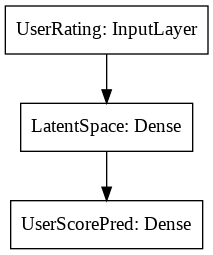

In [69]:
plot_model(autorec)

In [70]:
hist_Autorec = autorec.fit(x=users_items_matrix_train_zero,
                           y=users_items_matrix_train_zero,
                           epochs=500,
                           batch_size=256,
                           verbose=2,
                           validation_split=0.4) # validation_split=0.5 이면 validation error는 점점 증가한다.                           
#validation_data= [x_val, y_val] 

Epoch 1/500
15/15 - 0s - loss: 6.3920 - masked_rmse_clip: 1.9253 - val_loss: 2.8355 - val_masked_rmse_clip: 1.3503
Epoch 2/500
15/15 - 0s - loss: 2.0898 - masked_rmse_clip: 1.1384 - val_loss: 2.0109 - val_masked_rmse_clip: 1.1356
Epoch 3/500
15/15 - 0s - loss: 1.6205 - masked_rmse_clip: 0.9848 - val_loss: 1.7435 - val_masked_rmse_clip: 1.0561
Epoch 4/500
15/15 - 0s - loss: 1.4165 - masked_rmse_clip: 0.9187 - val_loss: 1.6353 - val_masked_rmse_clip: 1.0390
Epoch 5/500
15/15 - 0s - loss: 1.2454 - masked_rmse_clip: 0.8618 - val_loss: 1.5627 - val_masked_rmse_clip: 1.0336
Epoch 6/500
15/15 - 0s - loss: 1.1391 - masked_rmse_clip: 0.8270 - val_loss: 1.4932 - val_masked_rmse_clip: 1.0168
Epoch 7/500
15/15 - 0s - loss: 1.0419 - masked_rmse_clip: 0.7870 - val_loss: 1.4470 - val_masked_rmse_clip: 1.0055
Epoch 8/500
15/15 - 0s - loss: 0.9707 - masked_rmse_clip: 0.7541 - val_loss: 1.4317 - val_masked_rmse_clip: 1.0050
Epoch 9/500
15/15 - 0s - loss: 0.9108 - masked_rmse_clip: 0.7223 - val_loss: 1.4

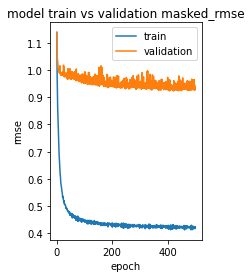

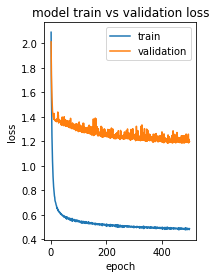

In [74]:
plt.subplot(121)
show_rmse(hist_Autorec, 1)

plt.subplot(122)
show_error(hist_Autorec, 1)

In [76]:
test_result = autorec.evaluate(users_items_matrix_train_zero, users_items_matrix_train_zero)
test_result

189/189 [==============================] - 0s 2ms/step - loss: 0.7692 - masked_rmse_clip: 0.6286


[0.7692089080810547, 0.6285620927810669]

In [77]:
predict_autorec = autorec.predict(users_items_matrix_train_zero)
predict_autorec

array([[5.2296963, 2.9701872, 3.0356727, ..., 2.9981663, 3.77356  ,
        3.3010252],
       [2.575172 , 3.4242377, 1.0646747, ..., 2.8876922, 3.6688023,
        3.621992 ],
       [2.6191723, 3.1613035, 1.6791337, ..., 2.5274096, 3.701448 ,
        2.9538279],
       ...,
       [1.981902 , 3.1500528, 1.6723788, ..., 2.1541312, 3.4149163,
        2.7338006],
       [2.7830074, 2.8322215, 1.0403907, ..., 2.421474 , 3.4775598,
        2.8651047],
       [3.6421125, 1.7800937, 0.9850867, ..., 2.8677247, 3.9989252,
        2.7911086]], dtype=float32)

In [81]:
K.constant(users_items_matrix_train_zero)

<tf.Tensor: shape=(6040, 3952), dtype=float32, numpy=
array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [82]:
masked_rmse_clip(K.constant(users_items_matrix_train_zero), K.constant(predict_autorec))

<tf.Tensor: shape=(6040,), dtype=float32, numpy=
array([0.31253636, 0.435333  , 0.31702596, ..., 0.7735809 , 0.7925162 ,
       0.91628164], dtype=float32)>

In [78]:
loss = K.eval(masked_rmse_clip(
    K.constant(users_items_matrix_train_zero),
    K.constant(predict_autorec)))

loss

array([0.31253636, 0.435333  , 0.31702596, ..., 0.7735809 , 0.7925162 ,
       0.91628164], dtype=float32)

In [79]:
np.mean(loss)

0.6285622

In [83]:
save_model('AutoEncoder_model', autorec)

Saved model to disk


In [84]:
model = load_model('AutoEncoder_model')
model

Loaded model from disk


In [86]:
model.compile(loss=masked_se, metrics=[masked_rmse_clip])
score = model.evaluate(users_items_matrix_train_zero, users_items_matrix_train_zero)
score

189/189 [==============================] - 0s 2ms/step - loss: 91.0380 - masked_rmse_clip: 0.6286


[91.03797912597656, 0.6285620927810669]

In [87]:
def AutoRec_LReLU(X, reg):

  input_layer = x = Input(shape=(X.shape[1], ), name='UserRating')

  x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)

  # As LReLU is not implemented in to Dense, need to have seperate Leakyrelu layer
  x = LeakyReLU()(x) # Activation function which uses negative values

  output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)

  return Model(input_layer, output_layer)

In [88]:
autorec_lrelu = AutoRec_LReLU(users_items_matrix_train_zero, 0.0005)
autorec_lrelu.compile(loss=masked_mse, metrics=[masked_rmse_clip])
autorec_lrelu.summary()
# 하나의 유저벌로 시행해서 shape가 none

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 500)               0         
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


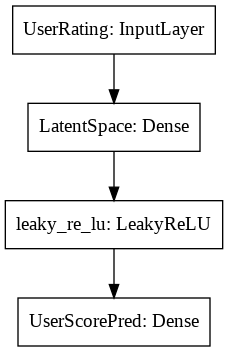

In [89]:
plot_model(autorec_lrelu)

In [90]:
hist_Autorec_lrelu = autorec_lrelu.fit(x=users_items_matrix_train_zero,
                           y=users_items_matrix_train_zero,
                           epochs=500,
                           batch_size=256,
                           verbose=2,
                           validation_split=0.4)                        
#validation_data= [x_val, y_val] 

Epoch 1/500
15/15 - 0s - loss: 8.3486 - masked_rmse_clip: 2.1863 - val_loss: 5.6475 - val_masked_rmse_clip: 2.0339
Epoch 2/500
15/15 - 0s - loss: 4.3395 - masked_rmse_clip: 1.6554 - val_loss: 4.0124 - val_masked_rmse_clip: 1.6103
Epoch 3/500
15/15 - 0s - loss: 3.3846 - masked_rmse_clip: 1.4620 - val_loss: 4.1819 - val_masked_rmse_clip: 1.7298
Epoch 4/500
15/15 - 0s - loss: 3.0790 - masked_rmse_clip: 1.3805 - val_loss: 3.4105 - val_masked_rmse_clip: 1.5013
Epoch 5/500
15/15 - 0s - loss: 2.5467 - masked_rmse_clip: 1.2513 - val_loss: 3.9821 - val_masked_rmse_clip: 1.7227
Epoch 6/500
15/15 - 0s - loss: 2.4635 - masked_rmse_clip: 1.2262 - val_loss: 3.2701 - val_masked_rmse_clip: 1.4098
Epoch 7/500
15/15 - 0s - loss: 2.2575 - masked_rmse_clip: 1.1571 - val_loss: 3.0971 - val_masked_rmse_clip: 1.4568
Epoch 8/500
15/15 - 0s - loss: 2.0218 - masked_rmse_clip: 1.0685 - val_loss: 2.9077 - val_masked_rmse_clip: 1.3656
Epoch 9/500
15/15 - 0s - loss: 1.8768 - masked_rmse_clip: 1.0368 - val_loss: 3.4

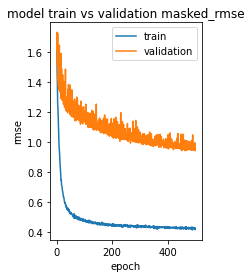

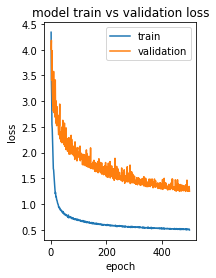

In [93]:
plt.subplot(121)
show_rmse(hist_Autorec_lrelu, 1)

plt.subplot(122)
show_error(hist_Autorec_lrelu, 1)

# Deep AutoEncoder Collaborative filtering

In [94]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
  '''
  INPUT
    X: user * item
    layers: List, each element is the number of neuron for a layer
    activation: activation function for all dense layer except the last
    dropout: dropout rate
    훈련할 때 임의의 뉴런의 연결을 끊는다. 즉, 매번 다른 뉴런을 학습시키는 것이다. (test시에는 모든 뉴런을 사용한다.)
    regularizer_encode: regularizer for encoder, 과적합 방지를 위한 모수 조정
    side_infor_size: size of the one hot encoding side information
                    item 변수 외에 다른 변수가 존재할 때 그 변수들의 개수

  OUTPUT
    keras model
  '''
  
  # input
  input_layer = x =Input(shape=(X.shape[1], ), name='UserRating')

  # encoder
  k = int(len(layers)/2) # encoding & decoding layer
  
  i = 0
  for l in layers[:k]:
    x = Dense(l, activation=activation, kernel_regularizer=regularizers.l2(regularizer_encode), name='EncLayer{}'.format(i))(x)
    i = i+1

  # Latent space: Representation of compressed data
  x = Dense(layers[k], activation=activation, kernel_regularizer=regularizers.l2(regularizer_encode), name='Latentspace')(x)

  # Dropout
  # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  # Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
  x = Dropout(rate=dropout)(x)

  # Decoder
  for l in layers[k+1:]:
    i = i-1
    x = Dense(l, activation=activation, kernel_regularizer=regularizers.l2(regularizer_decode), name='DecLayer{}'.format(i))(x)

  # Output
  output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, kernel_regularizer=regularizers.l2(regularizer_decode), name='UserScorePred')(x)

  return Model(input_layer, output_layer)

In [95]:
int(2.9) # floor

2

In [96]:
print(np.arange(5))
print(np.arange(5)[:2])
print(np.arange(5)[2])
print(np.arange(5)[3:])

[0 1 2 3 4]
[0 1]
2
[3 4]


In [97]:
ex = np.arange(10).reshape(5,2).astype(np.float32)
ex

array([[0., 1.],
       [2., 3.],
       [4., 5.],
       [6., 7.],
       [8., 9.]], dtype=float32)

In [98]:
tf.random.set_seed(0)
layer = Dropout(0.2)
layer(ex, training=True)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.  ,  1.25],
       [ 2.5 ,  3.75],
       [ 5.  ,  6.25],
       [ 7.5 ,  8.75],
       [10.  ,  0.  ]], dtype=float32)>

In [99]:
layers = [256, 512, 256]
dropout=0.8
activation='selu'
last_activation='selu'
regularizer_encode=0.001
regularizer_decode =0.001

In [100]:
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(loss=masked_mse, metrics=[masked_rmse_clip])
Deep_AE.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
Latentspace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
____________________________________________

In [101]:
3952 * 256 + 256

1011968

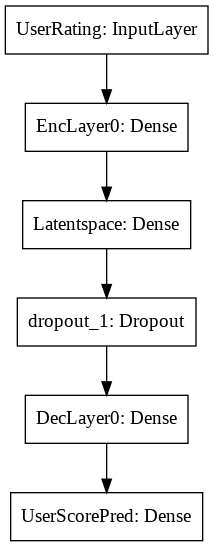

In [102]:
plot_model(Deep_AE)

In [103]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                           epochs=500, batch_size=256, verbose=2,
                           validation_split=0.4)#validation_data=[users_items_matrix_train_zero, users_items_matrix_validate]

Epoch 1/500
15/15 - 0s - loss: 6.6658 - masked_rmse_clip: 1.7620 - val_loss: 2.9567 - val_masked_rmse_clip: 1.2269
Epoch 2/500
15/15 - 0s - loss: 3.2378 - masked_rmse_clip: 1.2915 - val_loss: 2.6023 - val_masked_rmse_clip: 1.1281
Epoch 3/500
15/15 - 0s - loss: 2.8958 - masked_rmse_clip: 1.2298 - val_loss: 2.8341 - val_masked_rmse_clip: 1.2749
Epoch 4/500
15/15 - 0s - loss: 2.5705 - masked_rmse_clip: 1.1624 - val_loss: 2.3785 - val_masked_rmse_clip: 1.1084
Epoch 5/500
15/15 - 0s - loss: 2.3975 - masked_rmse_clip: 1.1329 - val_loss: 2.1546 - val_masked_rmse_clip: 1.0747
Epoch 6/500
15/15 - 0s - loss: 2.2328 - masked_rmse_clip: 1.1090 - val_loss: 2.0048 - val_masked_rmse_clip: 1.0389
Epoch 7/500
15/15 - 0s - loss: 1.9927 - masked_rmse_clip: 1.0486 - val_loss: 1.9519 - val_masked_rmse_clip: 1.0567
Epoch 8/500
15/15 - 0s - loss: 1.9469 - masked_rmse_clip: 1.0519 - val_loss: 1.8340 - val_masked_rmse_clip: 1.0264
Epoch 9/500
15/15 - 0s - loss: 1.7724 - masked_rmse_clip: 1.0075 - val_loss: 1.8

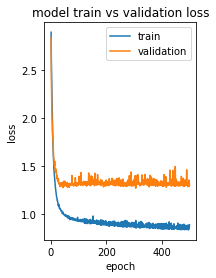

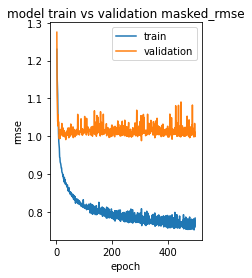

In [107]:
plt.subplot(121)
show_error(hist_Deep_AE, 2)

plt.subplot(122)
show_rmse(hist_Deep_AE, 2)

In [108]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)
predict_deep

array([[4.581609 , 4.673994 , 3.786433 , ..., 3.3857696, 3.4999223,
        3.6549873],
       [4.0235896, 3.5394943, 2.6128395, ..., 3.0513005, 3.4997659,
        4.056758 ],
       [3.3804457, 3.1926522, 3.9247322, ..., 2.337625 , 3.1491687,
        4.0552096],
       ...,
       [3.7203727, 3.848877 , 3.2836206, ..., 2.8198023, 3.488242 ,
        3.7575095],
       [4.0904207, 3.4619694, 2.642566 , ..., 3.496363 , 3.6741574,
        3.2642825],
       [3.7845285, 2.907426 , 1.8863312, ..., 3.5173466, 3.771692 ,
        3.4233162]], dtype=float32)

In [109]:
test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero, users_items_matrix_train_zero)
test_result_deep

189/189 [==============================] - 0s 2ms/step - loss: 1.0067 - masked_rmse_clip: 0.8439


[1.0067402124404907, 0.8439047336578369]

In [110]:
loss = K.eval(masked_rmse_clip(K.constant(users_items_matrix_train_zero), K.constant(predict_deep)))
np.mean(loss)

0.8439048

In [111]:
for layer in Deep_AE.layers:
  print(layer.get_config())

{'batch_input_shape': (None, 3952), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'UserRating'}
{'name': 'EncLayer0', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'Latentspace', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constrain

In [112]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]
first_layer_weights

array([[ 0.00406051, -0.00883912,  0.00303788, ...,  0.00019687,
        -0.000209  , -0.00533151],
       [-0.00274388, -0.01151944, -0.00018786, ..., -0.00230857,
        -0.00245843, -0.02125537],
       [-0.00350923,  0.04077549, -0.00105305, ..., -0.00038315,
        -0.00025159, -0.02419005],
       ...,
       [-0.00186037, -0.01418166, -0.00194464, ..., -0.0024936 ,
         0.00047453,  0.00413935],
       [ 0.001402  , -0.0136716 ,  0.00061317, ...,  0.00024552,
         0.00255464, -0.00181011],
       [-0.00477257, -0.0051675 , -0.00166126, ...,  0.00343643,
         0.00190379, -0.01619304]], dtype=float32)

In [113]:
first_layer_weights.shape

(3952, 256)

In [114]:
first_layer_weights[0].shape

(256,)

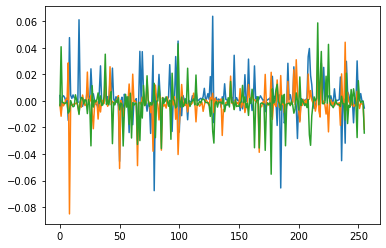

In [115]:
plt.plot(np.arange(0, 256, 1), first_layer_weights[0])
plt.plot(np.arange(0, 256, 1), first_layer_weights[1])
plt.plot(np.arange(0, 256, 1), first_layer_weights[2])
plt.show()

# Add Denoise
## Gaussian Noise
### Gaussian AutoRec

In [116]:
# Adding Gaussian noise to input
noise_factor = 0.4
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape)
users_items_matrix_train_zero_noisy

array([[ 5.38558688,  0.44092507,  0.81777971, ...,  0.47543014,
         0.16366345,  0.04129432],
       [ 0.811561  ,  0.05046151, -0.47730376, ..., -0.0338548 ,
         0.03311868, -0.54101314],
       [ 0.00738484,  0.51313267, -0.94927718, ...,  0.12910152,
         0.08771012,  0.62639547],
       ...,
       [ 0.09173244,  0.3714313 ,  0.5188481 , ...,  0.28698531,
         0.31191911,  0.74776475],
       [-0.36890427, -0.45331055,  0.0383455 , ..., -0.08490081,
         0.72555109, -0.43083935],
       [ 2.45060578, -0.86541607, -0.78557535, ...,  0.10892183,
        -0.08494951,  0.09101786]])

In [117]:
autorec_noisy = AutoRec(users_items_matrix_train_zero_noisy, 0.001, 'elu', 'elu')
autorec_noisy.compile(loss=masked_mse, metrics=[masked_rmse_clip])
autorec_noisy.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


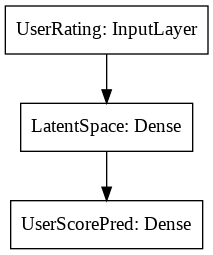

In [118]:
plot_model(autorec_noisy)

In [119]:
hist_Autorec_noisy = autorec_noisy.fit(x=users_items_matrix_train_zero_noisy,
                           y=users_items_matrix_train_zero,
                           epochs=500,
                           batch_size=256,
                           verbose=2,
                           validation_split=0.4)

Epoch 1/500
15/15 - 0s - loss: 7.2125 - masked_rmse_clip: 1.9459 - val_loss: 3.8682 - val_masked_rmse_clip: 1.4400
Epoch 2/500
15/15 - 0s - loss: 2.8744 - masked_rmse_clip: 1.1520 - val_loss: 3.1551 - val_masked_rmse_clip: 1.3034
Epoch 3/500
15/15 - 0s - loss: 2.2176 - masked_rmse_clip: 0.9673 - val_loss: 2.5878 - val_masked_rmse_clip: 1.1418
Epoch 4/500
15/15 - 0s - loss: 1.8536 - masked_rmse_clip: 0.8758 - val_loss: 2.3870 - val_masked_rmse_clip: 1.1629
Epoch 5/500
15/15 - 0s - loss: 1.5938 - masked_rmse_clip: 0.8212 - val_loss: 2.0972 - val_masked_rmse_clip: 1.0900
Epoch 6/500
15/15 - 0s - loss: 1.3876 - masked_rmse_clip: 0.7676 - val_loss: 2.0547 - val_masked_rmse_clip: 1.1216
Epoch 7/500
15/15 - 0s - loss: 1.2694 - masked_rmse_clip: 0.7410 - val_loss: 1.8768 - val_masked_rmse_clip: 1.0675
Epoch 8/500
15/15 - 0s - loss: 1.1921 - masked_rmse_clip: 0.7217 - val_loss: 1.8005 - val_masked_rmse_clip: 1.0529
Epoch 9/500
15/15 - 0s - loss: 1.1091 - masked_rmse_clip: 0.6913 - val_loss: 1.8

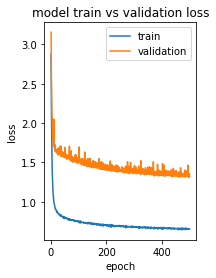

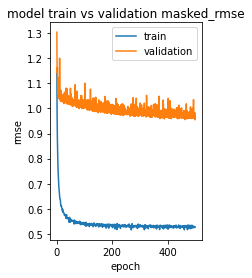

In [121]:
plt.subplot(121)
show_error(hist_Autorec_noisy, 1)

plt.subplot(122)
show_rmse(hist_Autorec_noisy, 1)

In [122]:
test_result_deep = autorec.evaluate(users_items_matrix_train_zero_noisy,
                                    users_items_matrix_train_zero)
test_result_deep

189/189 [==============================] - 0s 2ms/step - loss: 0.8002 - masked_rmse_clip: 0.6565


[0.8002004027366638, 0.6565494537353516]

# Gaussian Deep AE CF
## Noise + multi-layer

In [123]:
layers = [256, 512, 256]
dropout= 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [124]:
Deep_AE_denoise = Deep_AE_model(users_items_matrix_train_zero_noisy,
                                layers, activation, last_activation, dropout,
                                regularizer_encode, regularizer_decode)
Deep_AE_denoise.compile(loss=masked_mse, metrics=[masked_rmse_clip])
Deep_AE_denoise.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
Latentspace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
___________________________________________

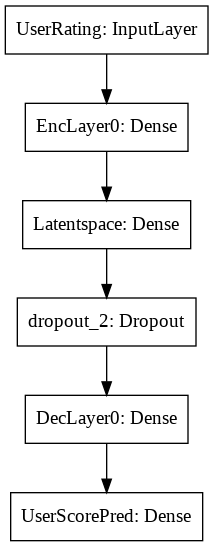

In [125]:
plot_model(Deep_AE_denoise)

In [126]:
hist_Deep_AE_denoise = Deep_AE_denoise.fit(x=users_items_matrix_train_zero_noisy,
                                           y=users_items_matrix_train_zero,
                                           epochs=500, batch_size=256,
                                           validation_split=0.4)

Epoch 1/500
15/15 [==============================] - 0s 24ms/step - loss: 7.1178 - masked_rmse_clip: 1.8298 - val_loss: 3.4496 - val_masked_rmse_clip: 1.3567
Epoch 2/500
15/15 [==============================] - 0s 13ms/step - loss: 3.4284 - masked_rmse_clip: 1.3081 - val_loss: 2.7712 - val_masked_rmse_clip: 1.1320
Epoch 3/500
15/15 [==============================] - 0s 13ms/step - loss: 3.0396 - masked_rmse_clip: 1.2236 - val_loss: 3.4014 - val_masked_rmse_clip: 1.4164
Epoch 4/500
15/15 [==============================] - 0s 13ms/step - loss: 2.7710 - masked_rmse_clip: 1.1690 - val_loss: 2.5542 - val_masked_rmse_clip: 1.1135
Epoch 5/500
15/15 [==============================] - 0s 13ms/step - loss: 2.6325 - masked_rmse_clip: 1.1489 - val_loss: 2.3393 - val_masked_rmse_clip: 1.0762
Epoch 6/500
15/15 [==============================] - 0s 12ms/step - loss: 2.4167 - masked_rmse_clip: 1.1053 - val_loss: 2.2147 - val_masked_rmse_clip: 1.0551
Epoch 7/500
15/15 [==============================] -

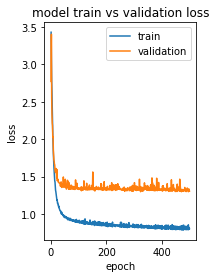

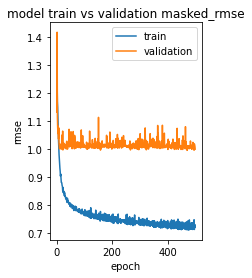

In [128]:
plt.subplot(1,2,1)
show_error(hist_Deep_AE_denoise, 1)

plt.subplot(1,2,2)
show_rmse(hist_Deep_AE_denoise, 1)

In [129]:
test_result_deep = Deep_AE_denoise.evaluate(users_items_matrix_train_zero_noisy)
loss = K.eval(masked_rmse_clip(K.constant(users_items_matrix_train_zero), K.constant(predict_deep)))
loss

189/189 [==============================] - 0s 2ms/step - loss: 0.2553 - masked_rmse_clip: 0.0000e+00


array([0.6219196 , 0.8720041 , 0.69076085, ..., 1.2753701 , 0.77199286,
       0.913127  ], dtype=float32)

In [130]:
np.mean(loss)

0.8439048

# Dropout Noise
(double dropout)


In [131]:
def Deep_AE_DropNoise_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, noise):

  input_layer = x = Input(shape=(X.shape[1], ), name='UserRating')

  # Dropout Noise (This is added)
  x = Dropout(rate = noise)(x)

  # Encoder
  k = int(len(layers)/2)
  i = 0
  for l in layers[:k]:
    x = Dense(l, activation=activation, kernel_regularizer=regularizers.l2(regularizer_encode),
              name='EncLayer{}'.format(i))(x)
    i = i+1

    # Latent space
    x = Dense(layers[k], activation=activation, name='LatentSpace',
              kernel_regularizer=regularizers.l2(regularizer_encode))(x)

    # Dropout
    x = Dropout(rate=dropout)(x)

    # Decoder
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, name='DecLayer{}'.format(i),
                kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # Output
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred',
                         kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    return Model(input_layer, output_layer)   

In [132]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
dropN = 0.1

Deep_AE_denoise_dropN = Deep_AE_DropNoise_model(users_items_matrix_train_zero,
                                                layers, activation, last_activation, dropout,
                                                regularizer_encode, regularizer_decode,
                                                dropN)
Deep_AE_denoise_dropN.compile(loss=masked_mse, metrics=[masked_rmse_clip])
Deep_AE_denoise_dropN.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3952)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)            

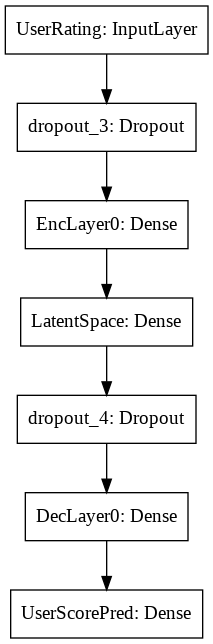

In [133]:
plot_model(Deep_AE_denoise_dropN)

In [134]:
hist_Deep_AE_denoise_dropN = Deep_AE_denoise_dropN.fit(x=users_items_matrix_train_zero_noisy,
                                               y=users_items_matrix_train_zero,
                                               epochs=500, batch_size=256, verbose=2,
                                               validation_split=0.4)

Epoch 1/500
15/15 - 0s - loss: 7.8255 - masked_rmse_clip: 1.8818 - val_loss: 3.0258 - val_masked_rmse_clip: 1.1821
Epoch 2/500
15/15 - 0s - loss: 3.5281 - masked_rmse_clip: 1.3258 - val_loss: 3.5239 - val_masked_rmse_clip: 1.4168
Epoch 3/500
15/15 - 0s - loss: 3.1677 - masked_rmse_clip: 1.2583 - val_loss: 2.6438 - val_masked_rmse_clip: 1.1138
Epoch 4/500
15/15 - 0s - loss: 2.8811 - masked_rmse_clip: 1.1980 - val_loss: 2.6203 - val_masked_rmse_clip: 1.1512
Epoch 5/500
15/15 - 0s - loss: 2.6537 - masked_rmse_clip: 1.1532 - val_loss: 2.4056 - val_masked_rmse_clip: 1.0895
Epoch 6/500
15/15 - 0s - loss: 2.4218 - masked_rmse_clip: 1.1065 - val_loss: 2.3479 - val_masked_rmse_clip: 1.0917
Epoch 7/500
15/15 - 0s - loss: 2.2656 - masked_rmse_clip: 1.0774 - val_loss: 2.1692 - val_masked_rmse_clip: 1.0709
Epoch 8/500
15/15 - 0s - loss: 2.1017 - masked_rmse_clip: 1.0433 - val_loss: 2.0432 - val_masked_rmse_clip: 1.0443
Epoch 9/500
15/15 - 0s - loss: 1.9681 - masked_rmse_clip: 1.0164 - val_loss: 1.9

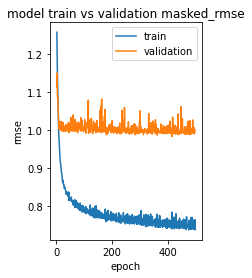

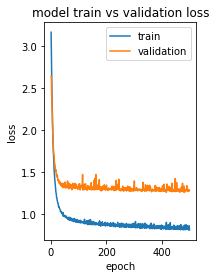

In [137]:
plt.subplot(1, 2, 1)
show_rmse(hist_Deep_AE_denoise_dropN, 2)

plt.subplot(1, 2, 2)
show_error(hist_Deep_AE_denoise_dropN, 2)

In [140]:
test_result_deep = Deep_AE_denoise_dropN.evaluate(users_items_matrix_train_zero,
                                                  users_items_matrix_train_zero)
test_result_deep

189/189 [==============================] - 0s 3ms/step - loss: 1.0612 - masked_rmse_clip: 0.8863


[1.061184287071228, 0.8862842321395874]

# Hybrid
## Preprocessing the side information

In [155]:
user_df = pd.read_table('users.dat', sep='::', header=None, usecols=[0, 1, 2, 3])
user_df.rename(columns={0:'user_emb_id', 1:'gender', 2:'age', 3:'occupation'}, inplace=True)
user_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,user_emb_id,gender,age,occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20
...,...,...,...,...
6035,6036,F,25,15
6036,6037,F,45,1
6037,6038,F,56,1
6038,6039,F,45,0


In [156]:
print(min(user_df.age))
print(max(user_df.age))

1
56


In [157]:
# Transform side information to onehot encoding
user_df['gender'] = preprocessing.LabelEncoder().fit(user_df['gender']).transform(user_df['gender'])
user_df['age'] = preprocessing.LabelEncoder().fit(user_df['age']).transform(user_df['age']) # Why age???
user_df

,user_emb_id,gender,age,occupation
0,1,0,0,10
1,2,1,6,16
2,3,1,2,15
3,4,1,4,7
4,5,1,2,20
...,...,...,...,...
6035,6036,0,2,15
6036,6037,0,4,1
6037,6038,0,6,1
6038,6039,0,4,0


In [158]:
onehot_df = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False).fit(user_df[['gender', 'age', 'occupation']]).transform(user_df[['gender', 'age', 'occupation']])
onehot_df

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [159]:
onehot_df.shape

(6040, 30)

In [160]:
print(len(user_df['gender'].unique()))
print(len(user_df['age'].unique())) # by 8
print(len(user_df['occupation'].unique()))

2
7
21


## Concatenate content to input keep output the same

In [161]:
# Concatenate the onehot side information to the rating matrix
user_items_user_info = np.concatenate((users_items_matrix_train_zero, onehot_df), axis=1)
user_items_user_info

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [162]:
user_items_user_info.shape

(6040, 3982)

In [163]:
Deep_AE_concate = Deep_AE_model(user_items_user_info, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, 30) # 30은 추가된 변수의 개수
Deep_AE_concate.compile(loss=masked_mse, metrics=[masked_rmse_clip])
Deep_AE_concate.summary() # More dimension -> more parameters

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3982)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1019648   
_________________________________________________________________
Latentspace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,298,224
Trainable params: 2,298,224
Non-trainable params: 0
___________________________________________

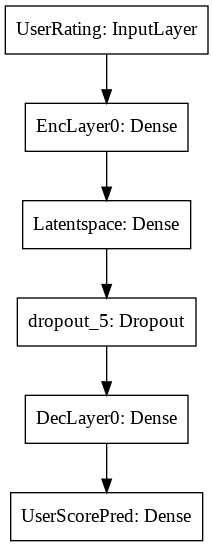

In [165]:
plot_model(Deep_AE_concate)

In [166]:
hist_Deep_AE_concate = Deep_AE_concate.fit(x=user_items_user_info,
                                           y=users_items_matrix_train_zero,
                                           epochs=500, batch_size=256, verbose=2,
                                           validation_split=0.4) # validation_data=[user_items_user_info, users_items_matrix_validate]

Epoch 1/500
15/15 - 0s - loss: 7.0922 - masked_rmse_clip: 1.7991 - val_loss: 2.8403 - val_masked_rmse_clip: 1.1745
Epoch 2/500
15/15 - 0s - loss: 3.2946 - masked_rmse_clip: 1.3033 - val_loss: 2.7806 - val_masked_rmse_clip: 1.2046
Epoch 3/500
15/15 - 0s - loss: 2.9326 - masked_rmse_clip: 1.2356 - val_loss: 2.4233 - val_masked_rmse_clip: 1.0879
Epoch 4/500
15/15 - 0s - loss: 2.7120 - masked_rmse_clip: 1.1975 - val_loss: 2.3715 - val_masked_rmse_clip: 1.1175
Epoch 5/500
15/15 - 0s - loss: 2.4400 - masked_rmse_clip: 1.1409 - val_loss: 2.1742 - val_masked_rmse_clip: 1.0612
Epoch 6/500
15/15 - 0s - loss: 2.2120 - masked_rmse_clip: 1.0906 - val_loss: 2.0950 - val_masked_rmse_clip: 1.0752
Epoch 7/500
15/15 - 0s - loss: 2.1116 - masked_rmse_clip: 1.0833 - val_loss: 1.9633 - val_masked_rmse_clip: 1.0474
Epoch 8/500
15/15 - 0s - loss: 1.9487 - masked_rmse_clip: 1.0460 - val_loss: 1.8623 - val_masked_rmse_clip: 1.0278
Epoch 9/500
15/15 - 0s - loss: 1.8005 - masked_rmse_clip: 1.0115 - val_loss: 1.8

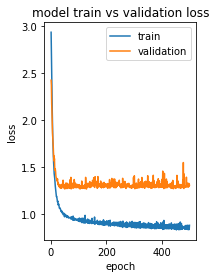

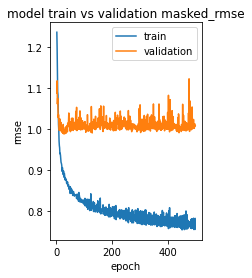

In [169]:
plt.subplot(1,2,1)
show_error(hist_Deep_AE_concate, 2)

plt.subplot(1,2,2)
show_rmse(hist_Deep_AE_concate, 2)

In [170]:
test_result_deep = Deep_AE_concate.evaluate(user_items_user_info, users_items_matrix_train_zero)
test_result_deep

189/189 [==============================] - 0s 2ms/step - loss: 1.0349 - masked_rmse_clip: 0.8598


[1.0349222421646118, 0.859786868095398]

# Other experiments

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d86f780b8>,
      dtype=object)

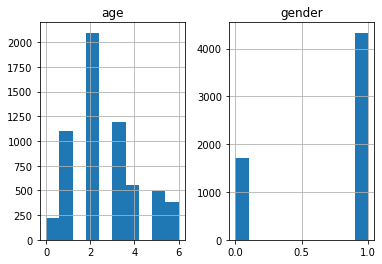

In [ ]:
user_df.hist(column=['age', 'gender'])

In [171]:
train_male_two = user_items_user_info[(user_items_user_info[:, 3953]==1) & (user_items_user_info[:, 3956]==1)]
# 3953은 남자
# 3956은 20대
train_male_two

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 4., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [174]:
train_male_two.shape

(1538, 3982)

In [175]:
Deep_AE_male = Deep_AE_model(train_male_two[:, :3952], layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_male.compile(loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_male.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
Latentspace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
___________________________________________

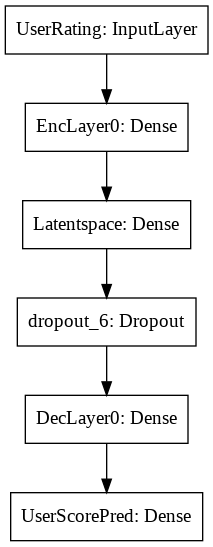

In [176]:
plot_model(Deep_AE_male)

In [177]:
hist_Deep_AE_male = Deep_AE_male.fit(x=train_male_two[:, :3952], y=train_male_two[:, :3952],
                  epochs=500,
                  batch_size=256,
                  validation_split=0.4, verbose=2) # validation_data=[train_male_two[:, :3952], validate_male_two[:, :3952]]

Epoch 1/500
4/4 - 0s - loss: 13.7182 - masked_rmse_clip: 2.5209 - val_loss: 4.9157 - val_masked_rmse_clip: 1.7440
Epoch 2/500
4/4 - 0s - loss: 4.6095 - masked_rmse_clip: 1.5649 - val_loss: 3.5459 - val_masked_rmse_clip: 1.4094
Epoch 3/500
4/4 - 0s - loss: 3.6384 - masked_rmse_clip: 1.3811 - val_loss: 2.7430 - val_masked_rmse_clip: 1.1292
Epoch 4/500
4/4 - 0s - loss: 3.1379 - masked_rmse_clip: 1.2523 - val_loss: 2.8756 - val_masked_rmse_clip: 1.2054
Epoch 5/500
4/4 - 0s - loss: 3.2325 - masked_rmse_clip: 1.2907 - val_loss: 2.5833 - val_masked_rmse_clip: 1.0993
Epoch 6/500
4/4 - 0s - loss: 2.9479 - masked_rmse_clip: 1.2187 - val_loss: 2.6143 - val_masked_rmse_clip: 1.1290
Epoch 7/500
4/4 - 0s - loss: 2.7727 - masked_rmse_clip: 1.1789 - val_loss: 2.4904 - val_masked_rmse_clip: 1.0917
Epoch 8/500
4/4 - 0s - loss: 2.8739 - masked_rmse_clip: 1.2090 - val_loss: 2.8197 - val_masked_rmse_clip: 1.2423
Epoch 9/500
4/4 - 0s - loss: 2.8579 - masked_rmse_clip: 1.2241 - val_loss: 2.4442 - val_masked_

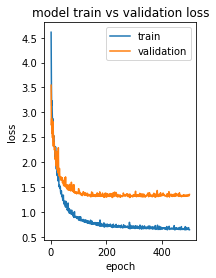

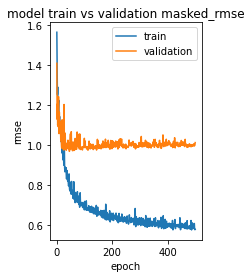

In [179]:
plt.subplot(1,2,1)
show_error(hist_Deep_AE_male, 1)

plt.subplot(1,2,1)
show_rmse(hist_Deep_AE_male, 1)

# Results (rmse clip)
* 기본: 1.2
* Leaky relu: 1.3
* Deep(2칸): 1
* 기본 + 잡음: 0.97
* Deep + 잡음: 1
* Deep + Drop out 2회: 1.3
* Deep + content: 1
* Deep + male: 1


# Reference
$\blacktriangleright$ https://github.com/RaptorMai/Deep-AutoEncoder-Recommendation/blob/master/DeepAE_Rec.ipynb